# 1.Benchmark data for 3D protein structure
### Why? Answer: We will have to test RNN Architecture on top of the generative model

In [1]:
from scipy.spatial import distance
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
from tensorflow.contrib import rnn

In [2]:
# some functions for random walk
rv = lambda : random.random()

amino_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
                    'I', 'J', 'K']
rv_amino = lambda : random.choice(['A', 'B', 'C', 'D', 'E'])
rv_letter = lambda : random.choice([1, 0, +1])

rv_int = lambda : random.randint(1,10)

def distPoints(a,b):
    return np.sqrt(np.sum(np.square(a-b)))

def dist_matrix(xyz):
    m, n = xyz.shape
    distMatrix = np.eye(m)
    for i in range(m):
        for j in range(m):
            distMatrix[i,j] += distPoints(xyz[i],xyz[j])
    return distMatrix

def one_hot(aminosequence):
    aminos = ['A', 'B', 'C', 'D', 'E']
    oneHots = np.array([])
    for ami in aminosequence:
        pos = aminos.index(ami)
        oneHot = np.zeros(len(aminos))
        oneHot[pos] = 1
        oneHots = np.append(oneHots, oneHot)
    return oneHots.reshape(len(aminosequence),len(aminos))

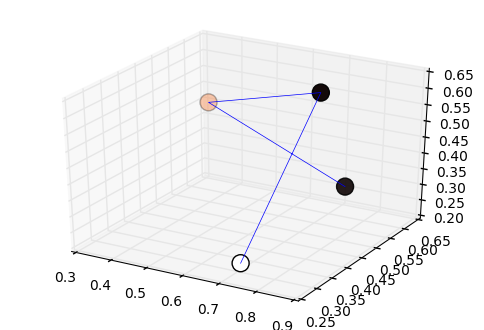

Example distance matrix: 
[[ 1.          0.54339207  0.26458457  0.27118046]
 [ 0.54339207  1.          0.44469002  0.57171526]
 [ 0.26458457  0.44469002  1.          0.45467213]
 [ 0.27118046  0.57171526  0.45467213  1.        ]]


In [3]:
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')

xyz = np.array([])
aminos = np.array([])
cur = [0, 0, 0]

N_amino = 4

for _ in range(N_amino):
    new_point = [rv() , rv(), rv()]
    xyz = np.append(xyz, new_point)
    new_amino = rv_int()
    aminos = np.append(aminos, new_amino)
    
cm = plt.get_cmap("RdYlGn")
xyz = xyz.reshape(N_amino,3)
x, y, z, l = xyz[:,0], xyz[:,1], xyz[:,2], aminos
ax.plot(x, y, z, label='Random walk', lw = .5)
ax.scatter(x, y, z, c=l, marker='o',  s=150, cmap='hot')   # End point

plt.show()
print("Example distance matrix: ")
print(dist_matrix(xyz))

# 2. Let us inject patterns / rules that should be learned!

In [4]:
# some artificial injected auto regressive pattern

def pattern01(xyz, amino_seq , new_letter, position):
    if position > 1:
        if (np.random.rand() > 0.4) & (distPoints(xyz[-6:-3],xyz[-3:]) < 0.2):
            new_letter = amino_seq[-1]
    return new_letter

In [5]:
def create_protein(N_amino=120):
    xyz = np.array([])
    amino_seq = ""
    for _ in range(N_amino):
        new_point = [rv() , rv(), rv()]
        xyz = np.append(xyz, new_point)
        new_letter = rv_amino()
        amino_seq += pattern01(xyz, amino_seq, new_letter, _)
    xyz = xyz.reshape(N_amino,3)
    return {amino_seq : [xyz,dist_matrix(xyz)]}

# 3. Create Dictionary with key=Aminosequence, value=3D coordinates

In [6]:
my_pdb = {}
proteinLength = 4
N_samples = 10

for _ in range(N_samples):
    my_pdb.update(create_protein(proteinLength))

# 4. Use a RNN architecture to predict elements in distance matrix

In [7]:
my_pdb.keys()

dict_keys(['DAAE', 'CDEE', 'BECC', 'ADDE', 'DCEE', 'AAAA', 'CEAC', 'ACCD', 'EEBE', 'CECE'])

In [8]:
dist = my_pdb['DAAE'][1]

In [45]:
dist[:2,1]

array([[ 1.13923558,  1.        ]])

In [20]:
ami[0] + ami[1]

'DA'

In [ ]:
ami = 'DAAE'
mn = len(ami)
start = np.eye(mn)
for i in range(mn):
    for j in range(mn):
        start[i,j] = 

In [11]:
one_hot('DAAE')

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [14]:
# Parameters
learning_rate = 0.001
training_iters = 100
batch_size = 1
display_step = 10

# Network Parameters
n_input = N_samples # samples
n_steps = N_samples # recurrent steps = number of columns
n_hidden = 128 # hidden layer num of features
n_classes = len(['A', 'B', 'C', 'D', 'E']) 

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape))

In [47]:
col00 = tf.placeholder("float", [None, 1])
col01 = tf.placeholder("float", [None, 2])
col02 = tf.placeholder("float", [None, 3])
col03 = tf.placeholder("float", [None, 4])

In [49]:
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()
    k = sess.run(col01, feed_dict={col01 : dist[:2,1].reshape(1,2)})
    print(k)

[[ 1.13923562  1.        ]]


In [ ]:


# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}


# full matrix vanilla RNN
############## NOTE

# has to change to cell wise matrix RNN

def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

In [ ]:

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()